Serial Time: 2.349122s
Parallel Time: 0.991589s


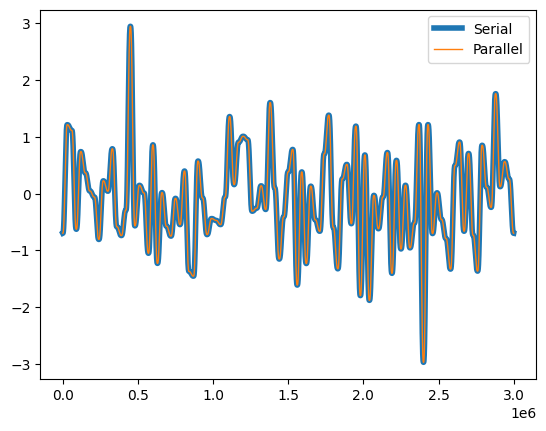

In [16]:
"""
# 1D Perlin Noise  
-----------------

El ruido de Perlin en 1D interpola valores aleatorios en un espacio continuo usando `fade` y `lerp`.

- `fade` suaviza la transición entre valores enteros.  
- `lerp` interpola los valores aleatorios.  

Pasos del proceso:  
1. Discretización: Se genera un array `x` en el rango deseado.  
2. Cálculo de índices y fracciones: Se obtienen `xi` (enteros) y `xf` (fracciones).  
3. Suavizado: Se aplica `fade(xf)` para mejorar la continuidad.  
4. Interpolación: Se usa `lerp(a, b, t)` para obtener valores intermedios.  

Usos:
En general (2D), se emplea en gráficos, simulaciones y generación procedural de terrenos para crear texturas y variaciones suaves. 

Nota: Estas implementaciones son _naive_, con fines demostrativos, sin aprovechar al máximo Numba ni `numpy`.

> https://es.wikipedia.org/wiki/Ruido_Perlin  
"""

from numba import njit, prange
import matplotlib.pyplot as plt
import numpy as np
import time

SIZE = 3_000_000
FREQUENCY = 100


@njit
def fade(t: float) -> float:
    return t * t * t * (t * (t * 6 - 15) + 10)


@njit
def lerp(a: float, b: float, t: float) -> float:
    return a + t * (b - a)


def perlin_1d_serial(size: int, frequency: int, grad: np.ndarray) -> np.ndarray:
    x = np.linspace(0, frequency, size)
    xi = np.floor(x).astype(np.int32)
    xf = x - xi
    u = fade(xf)

    values = np.empty(size)
    for i in range(size):
        values[i] = lerp(grad[xi[i] % frequency], grad[(xi[i] + 1) % frequency], u[i])
    return values


@njit(parallel=True)
def perlin_1d_parallel(size: int, frequency: int, grad: np.ndarray) -> np.ndarray:
    x = np.linspace(0, frequency, size)
    xi = np.floor(x).astype(np.int32)
    xf = x - xi
    u = fade(xf)

    values = np.empty(size)
    for i in prange(size):
        values[i] = lerp(grad[xi[i] % frequency], grad[(xi[i] + 1) % frequency], u[i])
    return values


grad = np.random.randn(frequency + 1)

serial_start = time.perf_counter()
values_serial = perlin_1d_serial(SIZE, FREQUENCY, grad)
serial_end = time.perf_counter()
print(f"Serial Time: {serial_end - serial_start:.6f}s")

parallel_start = time.perf_counter()
values_parallel = perlin_1d_parallel(SIZE, FREQUENCY, grad)
parallel_end = time.perf_counter()
print(f"Parallel Time: {parallel_end - parallel_start:.6f}s")

plt.plot(values_serial, label="Serial", linewidth=4)
plt.plot(values_parallel, label="Parallel", linewidth=1)
plt.legend()

plt.show()